# Spatially-informed Bivariate Metrics

## Environement Setup

In [1]:
import scanpy as sc
import decoupler as dc
import liana as li

from mudata import MuData

### Load and Normalize Data

TBD: Is this the data we want to use? If yes, I will write a couple of sentence about it

In [2]:
# TODO: upload this to Zenodo or something
adata = sc.read_h5ad('/media/dbdimitrov/SSDDimitrov/data/kuppe_visium/Visium_19_CK297.h5ad')
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [3]:
adata.obs.head()

in_tissue  array_row  array_col           sample  \
AAACAAGTATCTCCCA-1          1         50        102  Visium_19_CK297   
AAACAATCTACTAGCA-1          1          3         43  Visium_19_CK297   
AAACACCAATAACTGC-1          1         59         19  Visium_19_CK297   
AAACAGAGCGACTCCT-1          1         14         94  Visium_19_CK297   
AAACAGCTTTCAGAAG-1          1         43          9  Visium_19_CK297   

                    n_genes_by_counts  log1p_n_genes_by_counts  total_counts  \
AAACAAGTATCTCCCA-1               3125                 8.047510        7194.0   
AAACAATCTACTAGCA-1               3656                 8.204398       10674.0   
AAACACCAATAACTGC-1               3013                 8.011023        7339.0   
AAACAGAGCGACTCCT-1               4774                 8.471149       14235.0   
AAACAGCTTTCAGAAG-1               2734                 7.913887        6920.0   

                    log1p_total_counts  pct_counts_in_top_50_genes  \
AAACAAGTATCTCCCA-1            8.881142                   24.770642   
AAACAATCTACTAGCA-1            9.275660                   35.956530   
AAACACCAATAACTGC-1            8.901094                   33.247036   
AAACAGAGCGACTCCT-1            9.563529                   22.739726   
AAACAGCTTTCAGAAG-1            8.842316                   35.664740   

                    pct_counts_in_top_100_genes  pct_counts_in_top_200_genes  \
AAACAAGTATCTCCCA-1                    31.387267                    39.797053   
AAACAATCTACTAGCA-1                    42.167885                    49.456624   
AAACACCAATAACTGC-1                    39.910069                    47.227143   
AAACAGAGCGACTCCT-1                    29.884089                    37.850369   
AAACAGCTTTCAGAAG-1                    42.268786                    50.000000   

                    pct_counts_in_top_500_genes   mt_frac celltype_niche  \
AAACAAGTATCTCCCA-1                    54.503753  0.085630      ctniche_1   
AAACAATCTACTAGCA-1                    61.045531  0.033275      ctniche_5   
AAACACCAATAACTGC-1                    59.326884  0.029139      ctniche_5   
AAACAGAGCGACTCCT-1                    51.099403  0.149194      ctniche_7   
AAACAGCTTTCAGAAG-1                    62.384393  0.025601      ctniche_5   

                   molecular_niche  
AAACAAGTATCTCCCA-1      molniche_9  
AAACAATCTACTAGCA-1      molniche_3  
AAACACCAATAACTGC-1      molniche_3  
AAACAGAGCGACTCCT-1      molniche_2  
AAACAGCTTTCAGAAG-1      molniche_3

Spot clusters

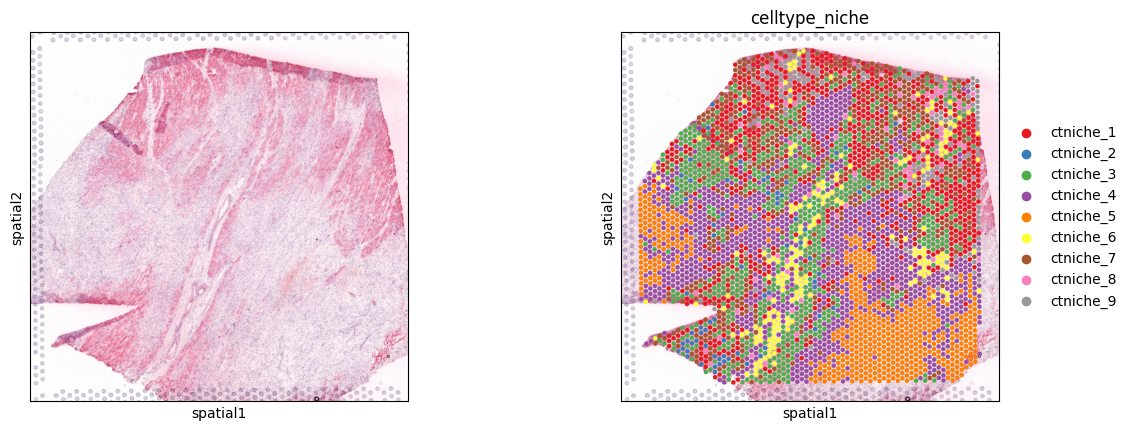

In [4]:
sc.pl.spatial(adata, color=[None, 'celltype_niche'], size=1.3, palette='Set1')

## Background

Here, we will demonstrate how to use the spatially-informed bivariate metrics to assess the spatial relationship between two variables. Specifically, we focus on local Bivariate Metrics. In contrast to most spatial Methods, including [Misty](); focusing on local spatial relationships enables us to pinpoint the exact location of spatial relationships, and to identify spatial relationships that might occur only in a specific sub-region of our samples.

Following the initial concept of LIANA, and inspired by [scHOT](https://www.nature.com/articles/s41592-020-0885-x), we have natively re-implemented **6** (I know they are 9 TBD) local bivariate metrics, including scHOT's (default) masked Spearman & [SpatialDM's](https://www.biorxiv.org/content/10.1101/2022.08.19.504616v1.full) local Moran's R.

As part of the LIANA+ manuscript, we performed two distinct tasks to evaluate the ability of these methods to preserve biological information, and saw that on average when used to identify local ligand-receptor relationships, spatially-weighted Cosine distance did best. Thus, we will focus on it throughout this tutorial. However, we expect that other scoring functions might be better suited for other tasks, e.g. Spatially-weighted Jaccard Similarity should be well suited for categorical data; thus we encourage you to explore them.

### Available Local Functions

In [5]:
li.mt.show_functions()

name                                   metadata  \
0          pearson   weighted Pearson correlation coefficient   
1         spearman  weighted Spearman correlation coefficient   
2           cosine                 weighted cosine similarity   
3          jaccard                weighted Jaccard similarity   
4           morans                                  Moran's R   
5   masked_pearson      masked & weighted Pearson correlation   
6  masked_spearman     masked & weighted Spearman correlation   
7    masked_cosine        masked & weighted cosine similarity   
8   masked_jaccard       masked & weighted Jaccard similarity   

                                           reference  
0                                               None  
1                                               None  
2                                               None  
3                                               None  
4  Li, Z., Wang, T., Liu, P. and Huang, Y., 2022....  
5                                               None  
6  Ghazanfar, S., Lin, Y., Su, X., Lin, D.M., Pat...  
7                                               None  
8                                               None

### How do they work?

The way these local functions work is quite simple, they are simply weighted versions of well known similarity metrics. For example, the spatially-weighted Cosine distance is defined as:

$$cos_w(c_j) = \frac{\sum_{i=1}^n w_{ij} x_{ij} y_{ij}}{\sqrt{\sum_{i=1}^n w_{ij} x_{ij}^2} \sqrt{\sum_{i=1}^n w_{ij} y_{ij}^2}}$$

where for each spot **cj**, we perform summation over all spots (**n**) at positions **i**; 
with weights **w** as the spot-specific proximity/weight between spot **j** and spot **i**;
and **x** and **y** being the vectors of the two variables. 

### Spatial Connectivity

The spatial weights in LIANA+ are by default defined as a family of radial kernels that use the inverse Euclidean distance between cells/spots to bind the weights between 0 and 1. However, LIANA's connectivities are flexible and can be defined in any way that fits the user. We have thus aligned LIANA's `spatial_neighbors` function to Squidpy's `spatial_neighbors` function, and one can easily replace LIANA's radial connecitivies with e.g. Squidpy's nearest neighbors graph, etc.

In [6]:
# NOTE: we use set_diag as True here, as we expect many cells to be neighbors of themselves within a visium spot
li.mt.spatial_neighbors(adata, bandwidth=150, cutoff=0.1, set_diag=True)

Let's visualize the spatial weights for a single spot (e.g. j) to all other spots in the dataset (e.g. i):

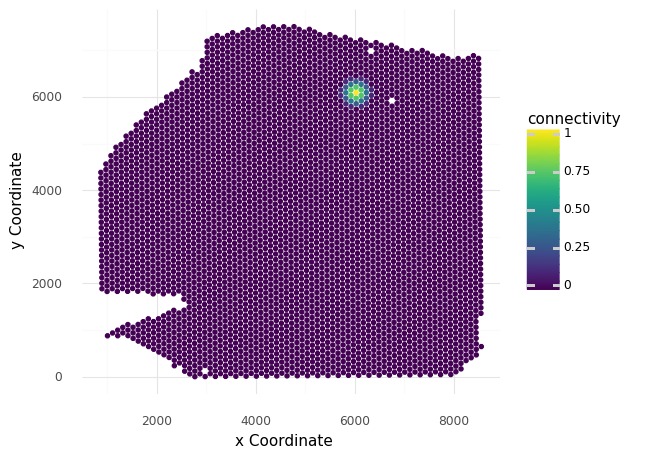

<ggplot: (8746821578975)>

In [7]:
li.pl.connectivity(adata, idx=0, size=1.3)

### Local Ligand-Receptor Relationships

Now that we have covered the basics, let's see how these scores look for potential ligand-receptor interactions on our 10X Visium Slide.
Note that LIANA+ will take the presence of heteromeric complexes into account at the individual spot-level!

In [8]:
li.mt.lr_bivar(adata, 
               function_name='cosine', # Name of the function
               n_perms=100, # Number of permutations to calculate a p-value
               positive_only=True, # Whether to focus on positive correlations only
               add_categories=True, # Whether to add local categories to the results
               expr_prop=0.2, # Minimum expr. proportion for ligands/receptors and their subunits
               use_raw=False,
               verbose=True
               )

Using `.X`!


100%|██████████| 100/100 [01:15<00:00,  1.33it/s]


Now that this is done, we can extract and explore the newly-created AnnData object that counts our local scores

In [9]:
lrdata = adata.obsm['local_scores']

In addition to the local scores, we can also extract the "global" scores for each pair of variables. For most local functions currently in LIANA+, These scores are calculated by averaging the local scores across all spots. We can use the "global" scores to choose the best pairs of variables to visualize:


In [22]:
lrdata.uns['global_res'].sort_values("global_mean", ascending=False).head(3)

ligand receptor  ligand_means  ligand_props  receptor_means  \
2758   TIMP1     CD63      3.048890      0.996839        2.887192   
266   LGALS1    ITGB1      3.534027      0.997326        2.457884   
274      LUM    ITGB1      3.173511      0.996353        2.457884   

      receptor_props   interaction  global_mean  global_sd  
2758        0.994165    TIMP1&CD63     0.982512   0.016920  
266         0.988330  LGALS1&ITGB1     0.979007   0.031898  
274         0.988330     LUM&ITGB1     0.964955   0.030367

In [24]:
lrdata.uns['global_res'].sort_values("global_sd", ascending=False).head(3)

ligand     receptor  ligand_means  ligand_props  receptor_means  \
2881  S100A1         RYR2      0.697087      0.572332        0.430792   
1796     VTN  ITGAV_ITGB5      0.434514      0.395089        1.108789   
1278     VTN  ITGAV_ITGB1      0.434514      0.395089        1.713479   

      receptor_props      interaction  global_mean  global_sd  
2881        0.406516      S100A1&RYR2     0.479849   0.280113  
1796        0.814977  VTN&ITGAV_ITGB5     0.534541   0.254590  
1278        0.929006  VTN&ITGAV_ITGB1     0.580779   0.252194

Visualize one of the top hits in terms of Global Mean Cosine Distance, and one of the hits with highest variance in terms of Global Mean Cosine Distance:

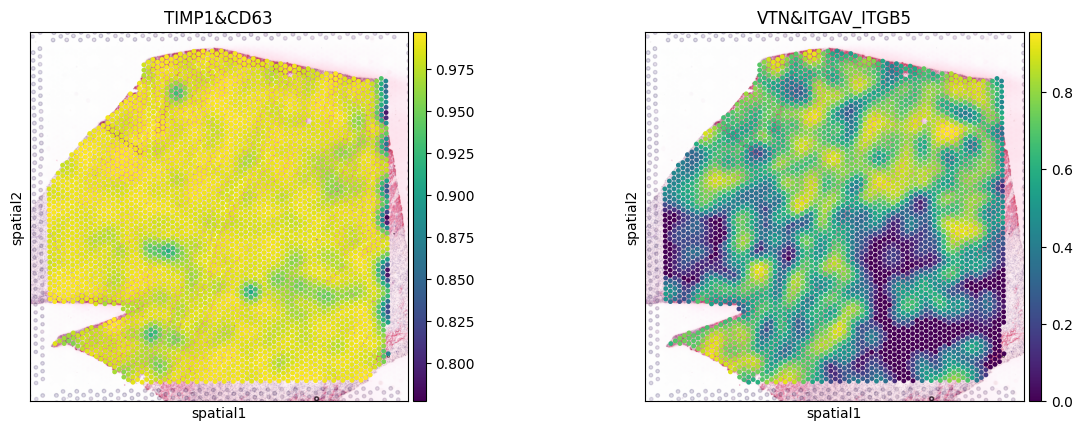

In [12]:
sc.pl.spatial(lrdata, color=['TIMP1&CD63', 'VTN&ITGAV_ITGB5'], size=1.4)

As largely expected, we see that the average Cosine similarly largely represents Coverage, as *TIMP1 & CD63* are roughly uniformly distributed across the slide. On the other hand, we look at the most variable pairs, we see that they are more likely to represent biological relationships, with distinct spatial clustering patterns.

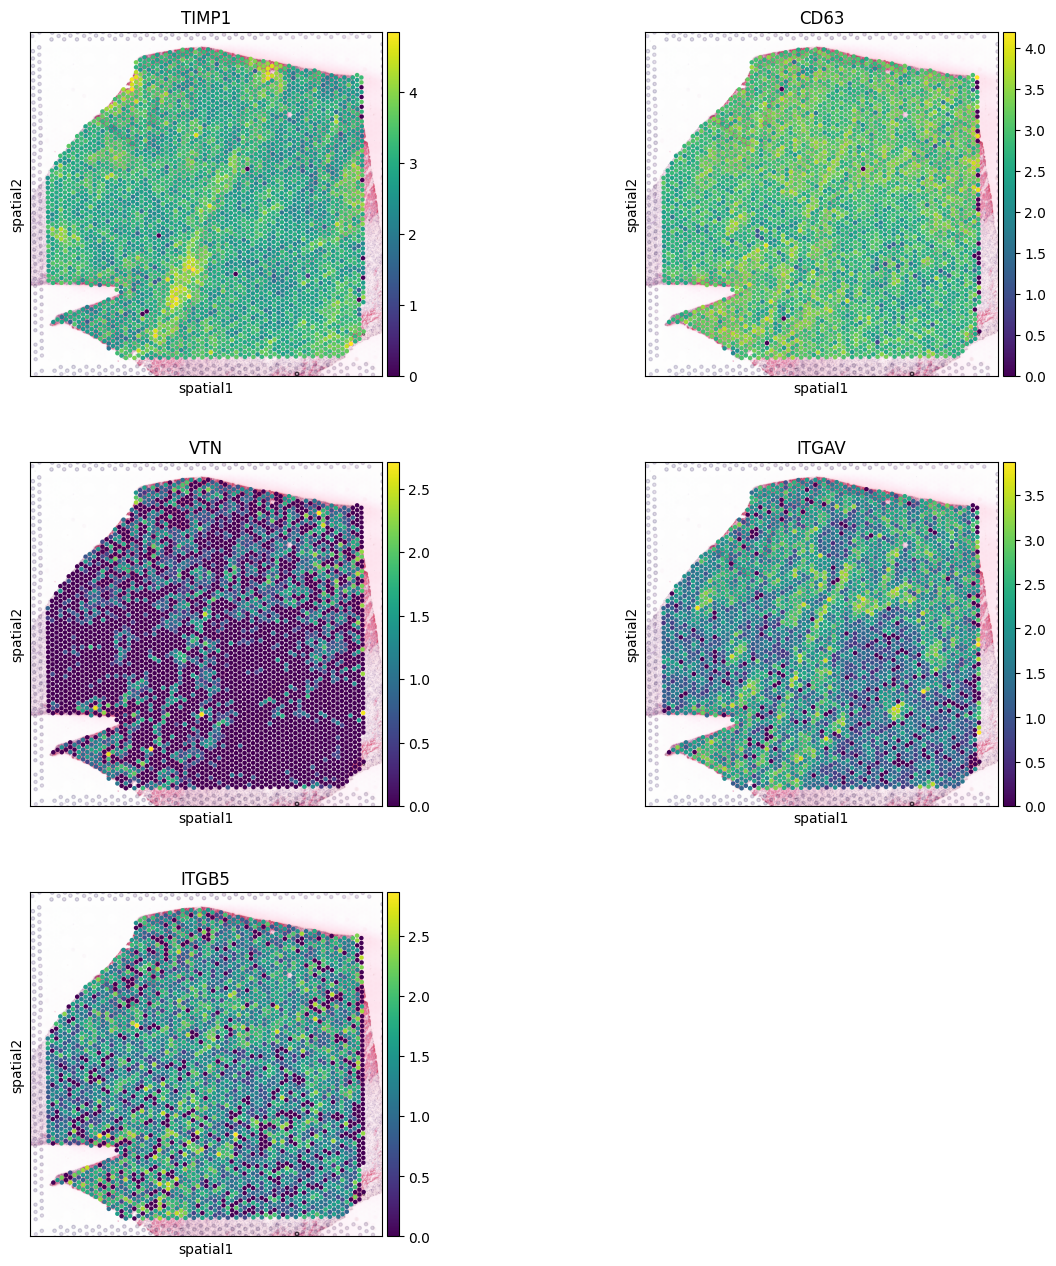

In [13]:
sc.pl.spatial(adata, color=['TIMP1', 'CD63', 'VTN',
                            'ITGAV', 'ITGB5'],
              size=1.4, ncols=2)

Nevertheless, if we look closely at VTN we can see that it's likely the gene that mostly defines the potential interaction, as the integrin complex (ITGAV, ITGA5) is uniformly expressed.

This also highlight a limitation when using the average or standard deviation of Cosine similarity - i.e. that we don't necessarily focus on interactions between genes that cluster exclusively. To this end, one can use Global bivariate Moran's R - an extension of univariate Moran's I, as proposed by [Anselin 2019](https://onlinelibrary.wiley.com/doi/abs/10.1111/gean.12164?casa_token=Ac3Bb4VIkZUAAAAA:4w9OFifNe33riCnMpNbkghd4ULDokXJ9H9YCqdxebK8yH2ZibqTIAoPRRSzfY9UmCAQBqH6y8FBBsLwgOg); and implemented initially in [SpatialDM](https://github.com/StatBiomed/SpatialDM).

### Global Moran's R

A nice property of Bivariate Moran's R is that it is bound between -1 (perfect negative spatial correlation) and 1 (perfect positive spatial correlation). Thus, it can be used to identify pairs of variables that are spatially clustered together, or apart.

In [14]:
global_morans, _, _, _ = li.mt.lr_bivar(adata, function_name="morans", inplace=False, use_raw=False, n_perms=None)

/home/dbdimitrov/Repos/liana-py/liana/method/sp/_spatial_pipe.py:354: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [15]:
global_morans.sort_values("global_r", ascending=False).head(5)

ligand      receptor  ligand_means  ligand_props  receptor_means  \
70        APOE          LRP1      1.179983      0.752006        1.937682   
2881    S100A1          RYR2      0.697087      0.572332        0.430792   
96    SERPING1          LRP1      1.711175      0.931437        1.937682   
1278       VTN   ITGAV_ITGB1      0.434514      0.395089        1.713479   
1479    COL1A1  ITGA11_ITGB1      5.487195      1.000000        0.719829   

      receptor_props          interaction  global_r global_pvals  
70          0.956236            APOE&LRP1  0.297608         None  
2881        0.406516          S100A1&RYR2  0.286779         None  
96          0.956236        SERPING1&LRP1  0.261377         None  
1278        0.929006      VTN&ITGAV_ITGB1  0.260025         None  
1479        0.643812  COL1A1&ITGA11_ITGB1  0.245056         None

In this case, we see that the *VTN&ITGAV_ITGB1* interaction is also among one of the interactions, whose gene members are among the most spatially-clustered ones, but it also gives us additional information that the clustering between these is not exactly ideal (~0.3); i.e. while there is indeed a positive relationship between the two members of this interaction, their co-expression is not necessarily exclusive. This might be due to the fact that the integrin complex is also expressed in other cell types, or because of the slightly noisy visium reads.

<div class="alert alert-info">
  Note, while Moran's R provides information about spatial clustering between two variables, it  is limited to two variables at a time and is thus not fit for complex, or non-linear, spatial relationships between variables. Thus, we also encourage the user to explore [LIANA+'s re-implementation of MISTy]() @dbdimitrov ADD LINK HERE.
</div>


### Permutation-based p-values
In addition to the local scores, we also calculated permutation-based p-values based on a null distribution generated by shuffling the spot labels. Let's see how these look for the tw interactions from above: 

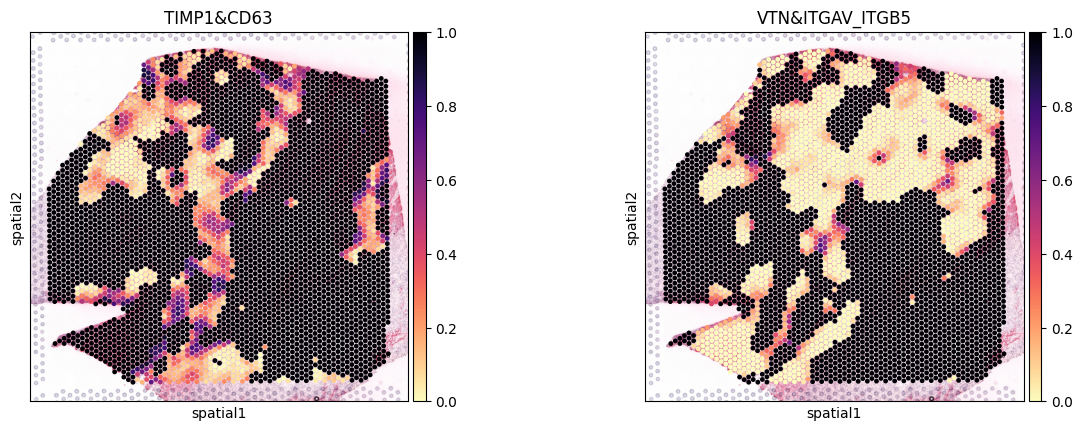

In [16]:
# swap to the p-value layer
dc.swap_layer(lrdata, 'pvals', inplace=True)
# plot p-values
sc.pl.spatial(lrdata, color=['TIMP1&CD63', 'VTN&ITGAV_ITGB5'], size=1.4, cmap="magma_r")

These largely agree with what we saw above for *VTN&ITGAV_ITGB1* as it more is specific to a certain region. However, the p-values for TIMP1&CD63 are likely less informative, as they are uniformly distributed across the slide.

### Local Categories

Did you notice that we used `positive_only` as a parameter when first estimating the interaction? This essentially means that we are only interested in positive interactions, i.e. such which occur at places in which both members of the interaction are highly expressed. The locations at which both members are highly- expressed is defined as follows:

We define the category of both **x** and **y** for each spot as follows:

$$ c_{ij} = \begin{cases}
\text{positive}, & \text{if } \sum_{i,j} (x_{ij} \cdot w_{ij}) > 0 \\
\text{negative}, & \text{if } \sum_{i,j} (x_{ij} \cdot w_{ij}) < 0 \\
\text{missing}, & \text{otherwise}
\end{cases} 
$$

Then we combine the categories of **x** and **y** for each spot, such that high-high are positive (1), high-low (or low-high) are -1; and low-low are 0.


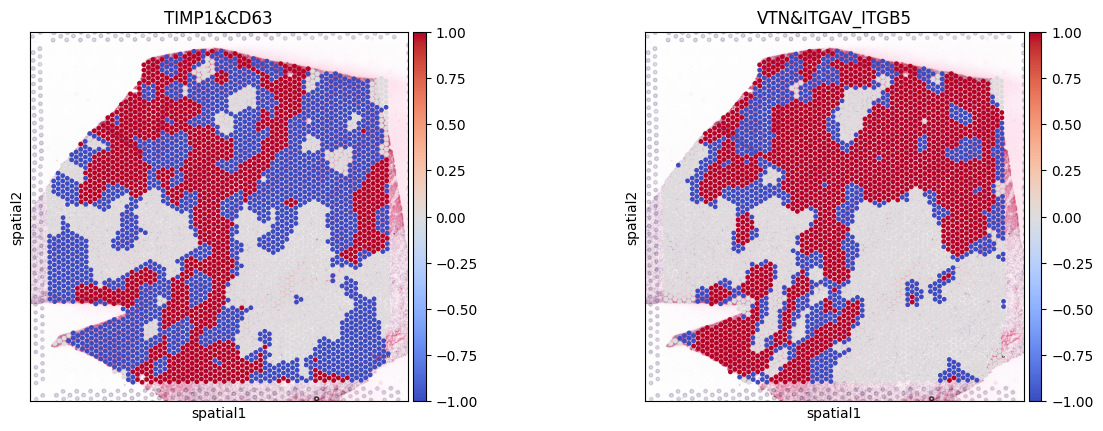

In [17]:
# swap to the p-value layer
dc.swap_layer(lrdata, 'cats', inplace=True)
# plot p-values
sc.pl.spatial(lrdata, color=['TIMP1&CD63', 'VTN&ITGAV_ITGB5'], size=1.4, cmap="coolwarm")

In [25]:
# TODO: Do I apply the pos_msk to the slide, maybe by default yes, but I should run it here with positive_only=False, at first?

## Beyond Ligand-Receptors

While protein-mediated ligand-receptor interactions are interesting, cell-cell communication is not limited to those alone. Rather it is a complex process that involves a variety of different mechanisms such as signalling pathways, metabolite-mediated signalling, and distinct cell types.

So, if such diverse mechanisms are involved in cell-cell communication, why should we limit ourselves to ligand-receptor interactions?
Let's see how we can use LIANA+ to explore other types of cell-cell communication.

One simple approach would be to check relationships e.g. between transcription factors and cell type proportions.

In [18]:
# extract cell type compositions
comps = li.fun.obsm_to_adata(adata, 'compositions')

In [19]:
# estimate Transciption factor activity
net = dc.get_collectri()
dc.run_ulm(adata, net = net, use_raw=False)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


KeyboardInterrupt: 

In [ ]:
est = li.fun.obsm_to_adata(adata, 'ulm_estimate')
##?? Replace with few ~ 50 spatially-variable genes? use squidpy to identify them.

In [ ]:
# We z-scale to make the distributions comparable
sc.pp.scale(comps)
sc.pp.scale(est)

In [ ]:
mdata = MuData({"tf":est, "comps":comps})
mdata.obsp = adata.obsp
mdata.uns = adata.uns
mdata.obsm = adata.obsm

In [ ]:
# TODO: Add verbose... to both...
li.mt.bivar(mdata, x_mod="tf", y_mod="comps", function_name="cosine", add_categories=True)

In [ ]:
mdata.mod['local_scores'].uns["global_res"].sort_values("global_sd")

In [ ]:
sc.pl.spatial(mdata.mod['local_scores'], color=['MEF2C^vSMCs', 'NKX2-5^CM'])

In [ ]:
dc.swap_layer(mdata.mod['local_scores'], 'cats', inplace=True)

In [ ]:
sc.pl.spatial(mdata.mod['local_scores'], color=['MEF2C^vSMCs', 'NKX2-5^CM'], cmap='coolwarm')

TODO: apply mask to local scores???